In [1]:
# Import modules

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

from models.dgplvm import DGPLVM

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Utility functions

def plot_scatter(
    X, y=None, title=None, color=None, n_annot=10, show_grid=True, color_bar=False
):
    if y is None:
        plt.scatter(X[:, 0], X[:, 1], alpha=0.3, c=color)
    else:
        plt.scatter(X[:, 0], X[:, 1], alpha=0.2, c=y, cmap="jet")

    if color_bar:
        plt.colorbar()

    if title is not None:
        plt.title(title)

    if show_grid:
        plt.grid()

    # argmax_z f(z)
    if y is not None:
        i_max = np.argsort(y)[-1]
        plt.scatter(X[i_max][0], X[i_max][1], alpha=0.5, c="red", marker="*", s=100)
        plt.annotate(i_max, (X[i_max][0], X[i_max][1]))

    n_annot = len(X) if len(X) < n_annot else n_annot
    for i in range(n_annot):
        plt.annotate(i, (X[:, 0][i], X[:, 1][i]))

In [3]:
# Load data

data = datasets.load_breast_cancer()

noise = np.random.normal(loc=0, scale=1.0, size=data.data.size).reshape(*data.data.shape)

X0 = StandardScaler().fit_transform(data.data) + noise
y0 = data.target

In [4]:
# Load data

df = pd.DataFrame(X0, columns=data.feature_names)
df['target'] = y0
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,0.627040,-0.317016,0.296775,1.997026,0.885574,3.995016,3.317571,2.956082,0.293442,1.285919,...,-0.847275,2.044524,0.325933,-0.436888,0.908710,2.123074,1.838493,1.927482,2.488555,0
1,1.123198,-1.411294,3.019968,1.489122,-3.391276,-1.825383,1.185214,1.666150,-0.500491,-0.902277,...,0.458730,2.372164,2.797879,0.522605,0.453112,-1.314853,1.000614,-0.428482,-1.143387,0
2,2.648916,0.644405,1.318831,3.402764,2.158527,-1.028585,0.518537,1.164504,1.888537,-0.433399,...,-1.013056,0.156542,3.899465,0.047517,1.302087,1.139671,2.693042,0.666371,0.428710,0
3,-1.028323,-0.639657,0.749856,-0.337165,-0.488529,2.991075,1.680313,0.720079,1.616219,4.731977,...,1.690325,0.347514,-0.018454,1.934256,4.073419,1.130229,2.676955,6.738637,7.337569,0
4,1.859653,0.623599,0.915566,2.603154,1.879016,0.627583,1.583728,2.676583,-0.798201,-1.891989,...,-1.504640,1.659463,1.964777,0.398322,0.275326,-0.142433,2.390506,-1.412280,-0.684908,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.893747,2.233400,1.960591,2.010204,0.714616,0.216944,2.561529,1.925278,-0.950641,-0.165480,...,0.633213,0.951690,1.756453,0.457187,-0.039022,1.629284,1.107862,-0.609480,-1.282592,0
565,1.297904,2.634252,1.977501,0.613586,0.137861,-0.626896,2.616733,1.834764,0.584277,-1.049876,...,2.128881,2.505101,0.749265,-0.788656,-0.299930,1.499631,1.062883,0.515526,-1.026492,0
566,-1.912573,2.291019,3.606392,-0.023035,-0.820691,-1.103761,-1.774531,-0.034010,-1.380886,-0.602717,...,0.653347,-1.131633,0.383085,-0.299217,-0.440225,0.465596,2.621797,0.186983,0.496260,0
567,1.299841,0.689641,0.325098,2.679124,1.990593,4.826277,4.027502,2.131509,-0.357014,1.905485,...,2.513027,-0.389156,1.814050,0.375743,3.970642,4.278419,1.924302,-0.069304,3.485921,0


In [5]:
# Data setting

noise = np.random.normal(loc=0, scale=1.0, size=data.data.size).reshape(*data.data.shape)
X0 = StandardScaler().fit_transform(data.data) + noise
y0 = data.target

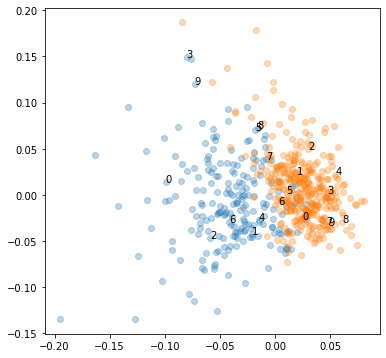

In [6]:
# SVD
u, s, vh = np.linalg.svd(X0, full_matrices=True)

plt.figure(figsize=(6, 6))
plot_scatter(u[:,:2][data.target==0])
plot_scatter(u[:,:2][data.target==1])

Early stopping at epoch=263
[tensor(1.4547, grad_fn=<CloneBackward0>), tensor(0.4726, grad_fn=<CloneBackward0>)]
[tensor(1.4710, requires_grad=True), tensor(0.4516, requires_grad=True)]


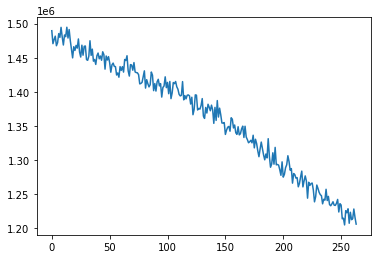

In [7]:
from models.gp_kernels import rbf_kernel

params = [
    torch.tensor(1.0, requires_grad=True),
    torch.tensor(1.0, requires_grad=True)
]

X = torch.tensor(X0.copy(), dtype=torch.float32)
y = torch.tensor(y0.copy(), dtype=torch.float32)#.reshape(-1, 1)

m = DGPLVM(rbf_kernel, kernel_params=params, optimize_params=params)

Z = m.fit(X, y, n_dim=2, n_epoch=2000, n_batch=32, min_epoch=200, n_patience=10, lr=1.0e-4, sigma_d=0.1)

# Learned params
print(m.kernel_params)
print(m.optimize_params)

# Loss plot
plt.plot(m.epoch_loss)

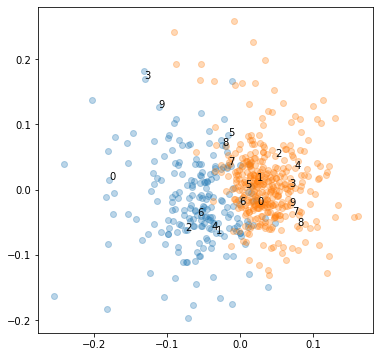

In [8]:
# Plot latent space

plt.figure(figsize=(6, 6))
plot_scatter(Z[y == 0.0], color_bar=False)
plot_scatter(Z[y == 1.0], color_bar=False)